In [1]:
from FAdo.fa import *
from FAdo.reex import *
from FAdo.fio import *
from FAdo.rndadfa import *

import lark

In [32]:
class CCount(Unary):
	def __init__(self, arg, min, max = None, sigma=None):
		self.arg = arg
		self.min = int(min)
		self.max = "inf" if max == -1 else max
		self.Sigma = sigma
	
	def __str__(self):
		"""String representation of the regular expression."""
		return '({}){{{},{}}}'.format(self.arg, self.min, self.max if self.max != "inf" else '')
	
	def _strP(self):
		"""String representation of the regular expression."""
		return '({}){{{},{}}}'.format(self.arg, self.min, self.max if self.max != "inf" else '')

	def __repr__(self):
		"""Representation of the regular expression's syntactical tree."""
		return 'CCount({},[{}])'.format(self.arg, self.min if not self.max else '{},{}'.format(self.min, self.max))
	
	def epsilonP(self):
		if self.max == "inf" or self.max == None:
			return self.min == 0
		else:
			m_v = int(self.max)
			return self.min == 0 and m_v == 0
		
	def ewp(self):
		return False

	def emptysetP(self):
		return False

	def linearForm(self): # https://www.dcc.fc.up.pt/~nam/resources/publica/51480046.pdf
		arg_lf = self.arg.linearForm()
		#print(arg_lf)
		lf = dict()
		for head in arg_lf:
			lf[head] = set()
			for tail in arg_lf[head]:
				if tail.emptysetP():
					lf[head].add(CEmptySet(self.Sigma))
				elif tail.epsilonP():
					if self.max == "inf" or self.max == None:
						if self.min - 1 == 0: #[n,m[
							lf[head].add(CStar(self.arg, self.Sigma))
						elif self.min - 1 == 1:
							lf[head].add(self.arg)
						else:
							self.min -= 1
							lf[head].add(self)
					else:
						mav = int(self.max)
						if mav-1 == self.min:
							lf[head].add(CEpsilon())
						elif mav-1 == self.min+1:
							lf[head].add(self.arg)
						else:
							self.max = mav - 1
							lf[head].add(self)
				else:
					if self.max == "inf" or self.max == None:
						if self.min - 1 == 0: #[n,m[
							lf[head].add(CConcat(tail, CStar(self.arg, self.Sigma), self.Sigma))
						elif self.min - 1 == 1:
							lf[head].add(CConcat(tail, self.arg, self.Sigma))
						else:
							self.min -= 1
							lf[head].add(CConcat(tail, self, self.Sigma))
					else:
						mav = int(self.max)
						if mav-1 == self.min:
							lf[head].add(CConcat(tail, CEpsilon(), self.Sigma))
						elif mav-1 == self.min+1:
							lf[head].add(CConcat(tail, self.arg, self.Sigma))
						else:
							self.max = mav - 1
							lf[head].add(CConcat(tail, self, self.Sigma))

		#print(lf)
					
		return lf

	def partialDerivatives(self, sigma):
		arg_pdset = self.arg.partialDerivatives(sigma)
		pds = set()
		for pd in arg_pdset:
			if pd.emptysetP():
				pds.add(CEmptySet(self.Sigma))
			elif pd.epsilonP():
				if self.max == "inf" or self.max == None:
					if self.min - 1 == 0: #[n,m[
						pds.add(CStar(self.arg, self.Sigma))
					elif self.min - 1 == 1:
						pds.add(self.arg)
					else:
						self.min -= 1
						pds.add(self)
				else:
					mav = int(self.max)
					if mav-1 == self.min:
						pds.add(CEpsilon())
					elif mav-1 == self.min+1:
						pds.add(self.arg)
					else:
						self.max = mav - 1
						pds.add(self)
			else:
				if self.max == "inf" or self.max == None:
					if self.min - 1 == 0: #[n,m[
						pds.add(CConcat(pd, CStar(self.arg, self.Sigma), self.Sigma))
					elif self.min - 1 == 1:
						pds.add(CConcat(pd, self.arg, self.Sigma))
					else:
						self.min -= 1
						pds.add(CConcat(pd, self, self.Sigma))
				else:
					mav = int(self.max)
					if mav-1 == self.min:
						pds.add(CConcat(pd, CEpsilon(), self.Sigma))
					elif mav-1 == self.min+1:
						pds.add(CConcat(pd, self.arg, self.Sigma))
					else:
						self.max = mav - 1
						pds.add(CConcat(pd, self, self.Sigma))
			# else:
			# 	pds.add(CConcat(pd, self, self.Sigma))
		return pds
	
	def derivative(self, sigma): # how ...?
		if self.max == "inf" or self.max == None:
			if self.min-1 == 0:
				return CStar(self.arg, self.Sigma)
			elif self.min-1 == 1:
				#print(self.min)
				return CConcat(self.arg, CStar(self.arg, self.Sigma), self.Sigma)
			else:
				self.min -= 1
				#print(self)
				return CConcat(self.arg, self, self.Sigma)
			# else:
			# 	d = self.arg.derivative(sigma)
			# 	if d == CEpsilon():
			# 		return CCount(self.arg, self.min-1, self.__in(), self.Sigma)
			# 	else:
			# 		return CCount(self.arg, self.min-1, self.__in(), self.Sigma)
		else:
			m_v = int(self.max)
			if self.min == m_v:
				return CEpsilon()
			elif self.min == m_v-1: # [1,2[
				return self.arg
			else:
				self.max = m_v-1
				return self

@epsilon (a){4,}


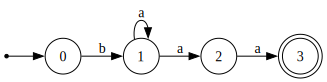

@epsilon (a){2,}


In [40]:
class BuildRegexpCC(BuildRegexp):
    def pow_min(self, s, inf=False):
        (arg, n_r) = s
        n = int(n_r.children[0].value)
        if inf:
            if n == 0:
                r = CStar(arg, self.sigma)
            else:
                r = CCount(arg, n, -1, self.sigma)
        else:
            r = CCount(arg, n, self.sigma)

        r._ewp = True

        return r

    def pow_minmax(self, s):
        (arg, n_mi, n_ma) = s
        n_min = n_mi.children[0].value
        n_max = n_ma.children[0].value
        r = CCount(arg, n_min, n_max, self.sigma)
        r._ewp = True
        return r
    def pow_inf(self, s):
        return self.pow_min(s, True)
    
regGrammar = lark.Lark.open("regexp_test.lark", start="rege", parser="lalr")

# available:
# b^[1] -> 'b'
# b^[1,2] -> 1 <= 'b' <= 2
# b^[1,...] -> 1 <= 'b' <= inf

tree = regGrammar.parse("b(a^[4,...])")	
reg = BuildRegexpCC(context={"sigma": None}).transform(tree)
print(reg.derivative('b'))
reg.toNFA(nfa_method="nfaPDNaive").display() # <= Ativar isto muda algum objeto da classe CCount????
print(reg.derivative('b'))
#reg.partialDerivatives('b')


In [70]:
x = str2regexp("a*")
x.derivative("a")

CConcat(CEpsilon(),CStar(CAtom(a)))